In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from collections import Counter
import math

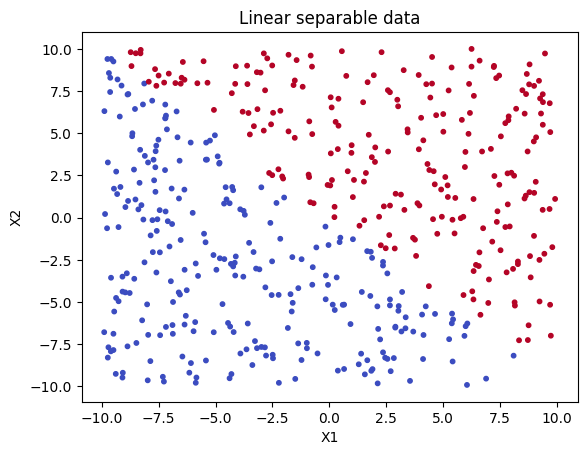

In [15]:
data = np.load('linear_separable_data.npz')
X = data['X']
y = data['y']

plt.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap="coolwarm")
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Linear separable data")
plt.show()

In [16]:
class DecisionTree:
    def __init__(self, max_depth=None, criterion="gini", percent_of_features=1.0):
        self.max_depth = max_depth
        self.criterion = criterion
        self.percent_of_features = percent_of_features
        self.tree = None

    def fit(self, X, y):
        self.tree = self.grow_tree(X, y)

    def grow_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        num_labels = len(set(y))

        # regularization - stop if max_depth is reached or if there is only one label
        if (depth >= self.max_depth or num_labels == 1):
            return {"label": Counter(y).most_common(1)[0][0]}
        
        best_split = self.best_split(X, y, num_features)

        if best_split["gain"] == 0:
            return {"label": Counter(y).most_common(1)[0][0]}

        left = self.grow_tree(best_split["X_left"], best_split["y_left"], depth + 1)
        right = self.grow_tree(best_split["X_right"], best_split["y_right"], depth + 1)

        return {
            "feature": best_split["feature"],
            "threshold": best_split["threshold"],
            "left": left,
            "right": right,
        }

    # Find the best split for the current node in the tree with respect to one feature
    # input: X, y, num_features
    # output: split -> dictionary containing the feature, threshold, gain, X_left, y_left, X_right, y_right
    def best_split(self, X, y, num_features):

        best_gain = -1
        feature, threshold, gain, X_left, X_right, y_left, y_right = None, None, None , None, None, None, None
        split = {
            "feature": feature,
            "threshold": threshold,
            "gain": gain,
            "X_left": X_left,
            "y_left": y_left,
            "X_right": X_right,
            "y_right": y_right,
        }
        
        ########## Your code goes here ##########
        if self.percent_of_features is not None:
            k = max(1, int(num_features * self.percent_of_features))
            features_to_consider = np.random.choice(num_features, k, replace=False)
        else:
            features_to_consider = range(num_features)


        for feature in features_to_consider:
            X_col = X[:, feature]
            thresholds = np.unique(X_col)
            for threshold in thresholds:
                gain, X_left, y_left, X_right, y_right = self.split(X, y, feature, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split = {
                        "feature": feature,
                        "threshold": threshold,
                        "gain": gain,
                        "X_left": X_left,
                        "y_left": y_left,
                        "X_right": X_right,
                        "y_right": y_right,
                    }
        ###########################################

        return split

    # split the data into two regions based on the feature and threshold and computes the information gain
    def split(self, X, y, feature, threshold):
        left_idx = X[:, feature] <= threshold
        right_idx = X[:, feature] > threshold
        X_left, y_left = X[left_idx], y[left_idx]
        X_right, y_right = X[right_idx], y[right_idx]

        if len(y_left) == 0 or len(y_right) == 0:
            return 0, X_left, y_left, X_right, y_right

        gain = self.information_gain(y, y_left, y_right)

        return gain, X_left, y_left, X_right, y_right

    # Compute the information gain
    # Note that you must weight the left and right child nodes by the number of samples in each
    def information_gain(self, y, y_left, y_right):

        gain = None

        ########## Your code goes here ##########
        n_left = len(y_left)
        n_right = len(y_right)
        if n_left == 0 or n_right == 0:
            return 0
        if self.criterion == "gini":
            impurity_parent = self.gini(y)
            impurity_left = self.gini(y_left)
            impurity_right = self.gini(y_right)
        else:
            impurity_parent = self.entropy(y)
            impurity_left = self.entropy(y_left)
            impurity_right = self.entropy(y_right)

        gain = impurity_parent - (n_left / (n_left + n_right)) * impurity_left - (n_right / (n_left + n_right)) * impurity_right

        ###########################################

        return gain

    # Compute the gini impurity
    def gini(self, y):

        gini_impurity = None

        ########## Your code goes here ##########
        _, counts = np.unique(y, return_counts=True)
        probs = counts / len(y)
        gini_impurity = 1 - np.sum(probs ** 2)

        ###########################################

        return gini_impurity

    # Compute the entropy
    def entropy(self, y):

        entropy_value = None

        ########## Your code goes here ##########
        _, counts = np.unique(y, return_counts=True)
        probs = counts / len(y)
        entropy_value = -np.sum(probs * np.log2(probs + 1e-9))
        ###########################################

        return entropy_value
    
    # Predict for a vector of inputs
    def predict(self, X):
        return np.array([self.predict_single(inputs, self.tree) for inputs in X])

    # Predict for a single input
    def predict_single(self, inputs, tree):
        if "label" in tree:
            return tree["label"]
        feature = tree["feature"]
        threshold = tree["threshold"]
        if inputs[feature] <= threshold:
            return self.predict_single(inputs, tree["left"])
        else:
            return self.predict_single(inputs, tree["right"])



# Implementing the Random Forest Algorithm

In the previous lab, we implemented the Decision Tree classifier. In this lab, we will build on that implementation to develop and test the Random Forest algorithm.

Before implementing the Random Forest, we need to add one more property to the Decision Tree, namely the percentage of features that will be sampled when determining the best split. This property is essential as described in the lab instructions.

Make a copy of the previous Decision Tree implementation and ensure the necessary changes are made to accommodate the new class variable `percent_of_features`, which represents the percentage of the total number of features per example.


In [17]:
class RandomForest():
    def __init__(self, n_trees=80, max_depth=5, criterion="gini", percent_of_features=None, percent_of_samples=None):
        # Initialize the random forest
        # input: n_trees -> number of trees in the forest
        #        max_depth -> maximum depth of the tree
        #        criterion -> criterion to use for splitting
        #        percent_of_features -> percentage of features to consider for each split
        #        percent_of_samples -> percentage of samples to consider for each tree

        self.n_trees = n_trees
        self.trees = [DecisionTree(max_depth=max_depth, criterion=criterion, percent_of_features=percent_of_features) for i in range(n_trees)]
        self.percent_of_samples = percent_of_samples

    def split_data(self, X, y, n_trees):

        # Split the data into n_trees number of samples
        # input: X -> data
        #        y -> labels
        #        n_trees -> number of trees
        # output: X_split -> list of data split into n_trees number of samples
        #         y_split -> list of labels split into n_trees number of samples
        # Note: Make sure the split is random and that after picking one sample, it can be picked again. Hint: np.random.choice

        X_split = []
        y_split = []
        for _ in range(n_trees):
            
            ########## Your code goes here ##########
            indices = np.random.choice(X.shape[0], X.shape[0], replace=True)
            X_split.append(X[indices])
            y_split.append(y[indices])

            ###########################################

        return X_split, y_split
    
    def fit(self, X, y):
        # Fit the random forest
        # input: X -> data
        #        y -> labels
        # Note: Split the data and fit each tree in the forest

        ########## Your code goes here ##########
        X_split, y_split = self.split_data(X, y, self.n_trees)
        for i in range(self.n_trees):
            self.trees[i].fit(X_split[i], y_split[i])
        ###########################################

    def predict(self, X):
        # Predict the label for each sample in X
        # input: X -> data
        # output: pred -> list of labels
            
        pred = None
        
        ########## Your code goes here ##########
        tree_preds = []
        for tree in self.trees:
            tree_preds.append(tree.predict(X))  # each is shape (n_samples,)

        tree_preds = np.array(tree_preds)  # shape: (n_trees, n_samples)

        # Majority vote
        pred = np.apply_along_axis(
            lambda x: np.bincount(x).argmax(),
            axis=0,
            arr=tree_preds
        )

        ###########################################

        return pred

    

In [18]:
forest = RandomForest(n_trees = 30, max_depth=5, criterion="gini", percent_of_features=0.5, percent_of_samples=0.5)
forest.fit(X, y)

tree = DecisionTree(max_depth=3, criterion="gini", percent_of_features=1.)
tree.fit(X, y)

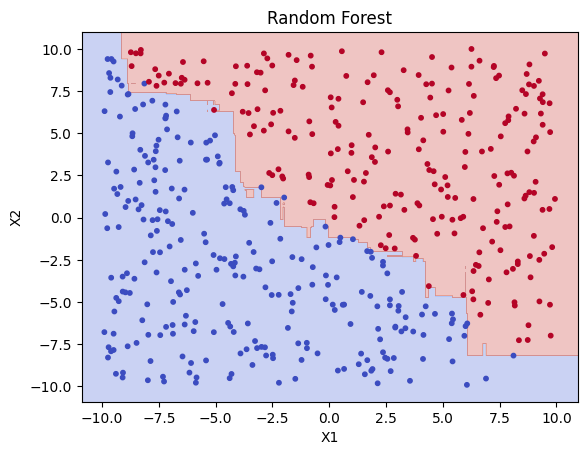

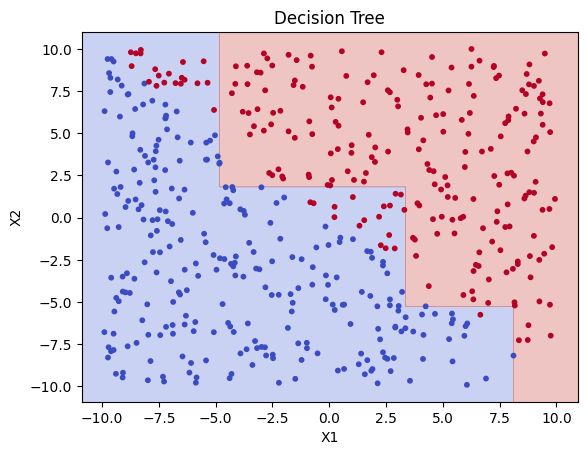

In [19]:
def plot_decision_boundaries(tree, X, y, title=""):
    # Define bounds of the plot
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # Create a grid of points with a small step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Use the classifier to predict the class at each grid point
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = tree.predict(grid)
    Z = Z.reshape(xx.shape)
    
    # Plot the contours
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
    plt.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap="coolwarm")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title(title)
    plt.show()

plot_decision_boundaries(forest, X, y, title="Random Forest")
plot_decision_boundaries(tree, X, y, title="Decision Tree")
